In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *

In [20]:
from classification import *
surf_models = [['waldo_simple'],]
sift_models = [['waldo_hard', 'waldo_mix']]
surf_clf = CombinedClassifier('surf', surf_models)
sift_clf = CombinedClassifier('sift', sift_models)
sift_classifier_fir = PreparedClassifier('waldo', 'hard')
sift_classifier_sec = PreparedClassifier('waldo', 'mix')

In [4]:
from detection import *
cascade_classifier = load_haar_classifier()

In [12]:
img_bboxes = []
img_path = os.path.join(os.getcwd(), 'datasets', 'JPEGImages', '074.jpg')
image = cv2.imread(img_path)
detections = []

In [6]:
haar_boxes = cascade_classifier.detectMultiScale(image, scaleFactor=1.05, minNeighbors=5,
                                                             minSize=(100, 100), maxSize=(400, 400))

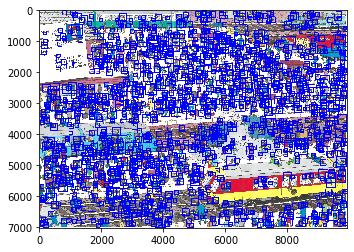

In [7]:
example = plt.imread(img_path)
for box in haar_boxes[:]:
    x = box[0]
    y = box[1]
    x_end = x + box[2]
    y_end = y + box[3]
    cv2.rectangle(example, (x, y), (x_end, y_end), (0, 0, 255), thickness=25)
plt.imshow(example)

In [14]:
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
for box in haar_boxes:
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    x_end = x + w
    y_end = min(y + int(h * 1.5), image.shape[0] - 1)
    
    hsv = hsv_img[y:y_end, x:x_end]
    hist = cv2.calcHist([hsv], [0], None, [10], [0, 180])
    hist /= hist.sum()
    if hist[[0, 1, -1]].sum() < 0.35 or hist[0] < 0.15:
        continue
    
    window = image[y:y_end, x:x_end]

    predict_score = surf_clf.predict_proba(window)
    if predict_score >= 0.7:
        detections.append((x, y, x_end, y_end, predict_score))

In [15]:
len(detections)

222

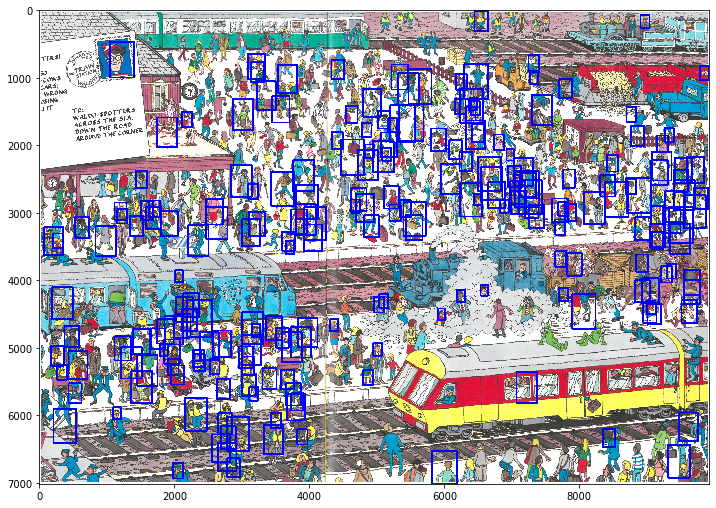

In [16]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)
example = plt.imread(img_path)
for (x1, y1, x2, y2, score) in detections[:]:
    cv2.rectangle(example, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
plt.imshow(example)

In [21]:
detections_second = []
for detection in detections:
    x, y, x_end, y_end, score = detection
    window = image[y:y_end, x:x_end]
    predict_score = sift_classifier_fir.predict_proba([window])[0][1]
    if predict_score > 0.7:
        detections_second.append((x, y, x_end, y_end, predict_score))

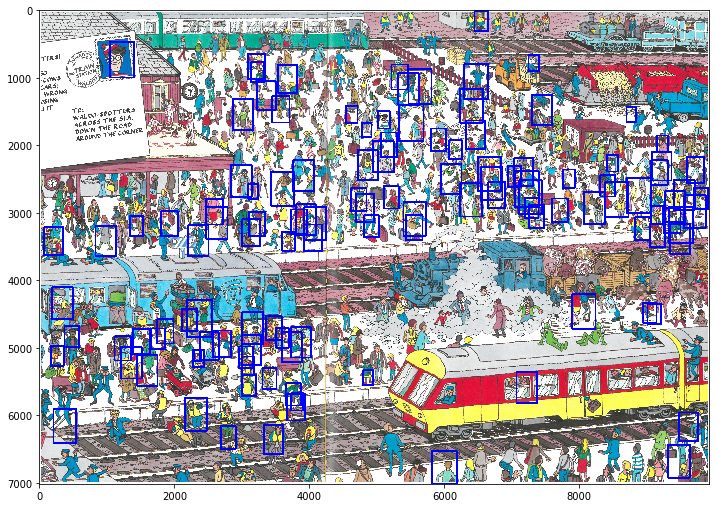

In [25]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)
example = plt.imread(img_path)
for (x1, y1, x2, y2, score) in detections_second[:]:
    cv2.rectangle(example, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
plt.imshow(example)

In [23]:
detections_third = []
for detection in detections_second:
    x, y, x_end, y_end, score = detection
    window = image[y:y_end, x:x_end]
    predict_score = sift_classifier_sec.predict_proba([window])[0][1]
    if predict_score > 0.7:
        detections_third.append((x, y, x_end, y_end, predict_score))

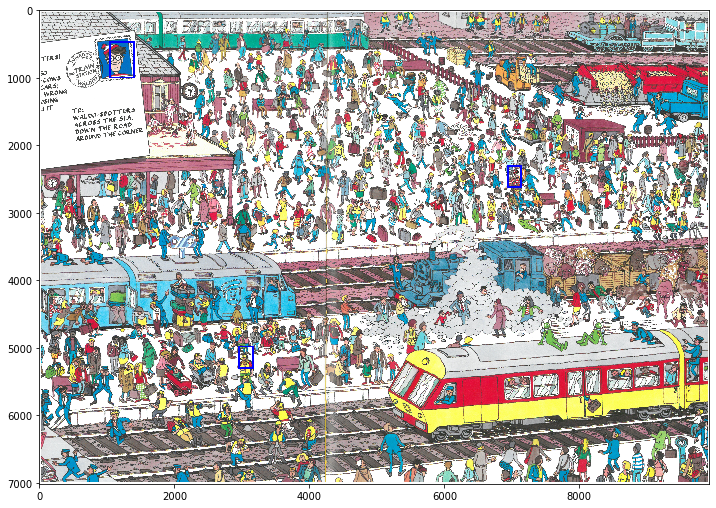

In [32]:
detections_forth = non_max_suppression(detections_third, threshold=0.5, score_threshold=0.99)
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)
example = plt.imread(img_path)
for (x1, y1, x2, y2, score) in detections_forth[:]:
    cv2.rectangle(example, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
plt.imshow(example)